# Watermark remover

This program requires a manual input of the position of the watermark. Then, a mask is generated and fed to the Stable Diffusion model together with the original image to remove the watermark.Then, we use an ESPCN model to enhance the resolution of the output image, then save it.

1. Import libraries and download the models:

In [8]:
import PIL
import requests
import torch
from io import BytesIO
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from diffusers import StableDiffusionInpaintPipeline
import matplotlib.pyplot as plt
from google.colab import files
import base64
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0
from jupyter_bbox_widget import BBoxWidget
import os
HOME = os.getcwd()
#load 4-time inssertion ESPCN from github
!wget -L https://raw.github.com/fannymonori/TF-ESPCN/master/export/ESPCN_x4.pb
time = 4
sr = cv2.dnn_superres.DnnSuperResImpl_create()
path = f"ESPCN_x{time}.pb"
sr.readModel(path)
sr.setModel("espcn", time)
#load Stable Diffusion model
pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
)
pipeline = pipeline.to("cuda")

--2025-04-05 11:12:07--  https://raw.github.com/fannymonori/TF-ESPCN/master/export/ESPCN_x4.pb
Resolving raw.github.com (raw.github.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/fannymonori/TF-ESPCN/master/export/ESPCN_x4.pb [following]
--2025-04-05 11:12:08--  https://raw.githubusercontent.com/fannymonori/TF-ESPCN/master/export/ESPCN_x4.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100323 (98K) [application/octet-stream]
Saving to: ‘ESPCN_x4.pb.2’

ESPCN_x4.pb.2       100%[===================>]  97.97K  --.-KB/s    in 0.002s  

2025-04-05 11:12:08 (39.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


2. Read the original image

In [13]:
#get image input
uploaded = files.upload()
path = list(uploaded.keys())[0]
init_image = PIL.Image.open(path).convert("RGB")
init_size = init_image.size
imgpath = os.path.join(HOME, path)

Saving watermark_0.png to watermark_0 (3).png


In [14]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

widget = BBoxWidget()
widget.image = encode_image(imgpath)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

3. process the annotation

In [15]:
default_box = {'x':68, 'y':247, 'width':555, 'height': 678, 'label':''}
box = widget.bboxes if widget.bboxes else [default_box]
b = box[0]
x1 = b['x']
y1 = b['y']
x2 = b['x'] + b['width']
y2 = b['y'] + b['height']

img = np.zeros((init_image.size[1],init_image.size[0]), dtype=np.uint8)
top_left = (x1, y1)
bottom_right = (x2, y2)
#generate the mask image
cv2.rectangle(img, top_left, bottom_right, (255), thickness=-1)
mask_image = np.array(img)

cv2.imwrite('mask.jpg', img)

True

4. Image preprocessing





In [16]:
init_image_r = init_image.resize((512,512))

#to fulfill the required format in pipeline()
mask_image = (mask_image > 128).astype(np.uint8) * 255
mask_image = PIL.Image.fromarray(mask_image)
mask_image_r = mask_image.resize((512,512))

5. Now, remove the watermark with Stable Diffusion. Consider that Stable Diffusion only accepts 512*512 input and output, we then enhance the resolution of the output image with ESPCN.

In [17]:
prompt = "Remove the watermark, restore the original image, super resolution, smooth edge."
image = pipeline(prompt=prompt, image=init_image_r, mask_image=mask_image_r).images[0]

#resize the image according to the width/height ratio of the initial image. we dont want the image be too
#small after processing, so let 512 be the length of the shorter edge (height or width).
hw = init_image.height / init_image.width
wh = init_image.width / init_image.height
mask_image = mask_image.resize(init_size)
if wh >= 1:
  h = int(512*wh)
  w = 512
else:
  h = 512
  w = int(512*hw)
image = np.array(image)
image = cv2.resize(image, (h, w), interpolation=cv2.INTER_CUBIC)

#super-resolution and save
result = sr.upsample(image)
image = cv2.resize(result, (h, w), interpolation=cv2.INTER_AREA)
final_image = PIL.Image.fromarray(np.array(image))
final_image.save("watermark-free.png")

  0%|          | 0/50 [00:00<?, ?it/s]

6. Save and show the result

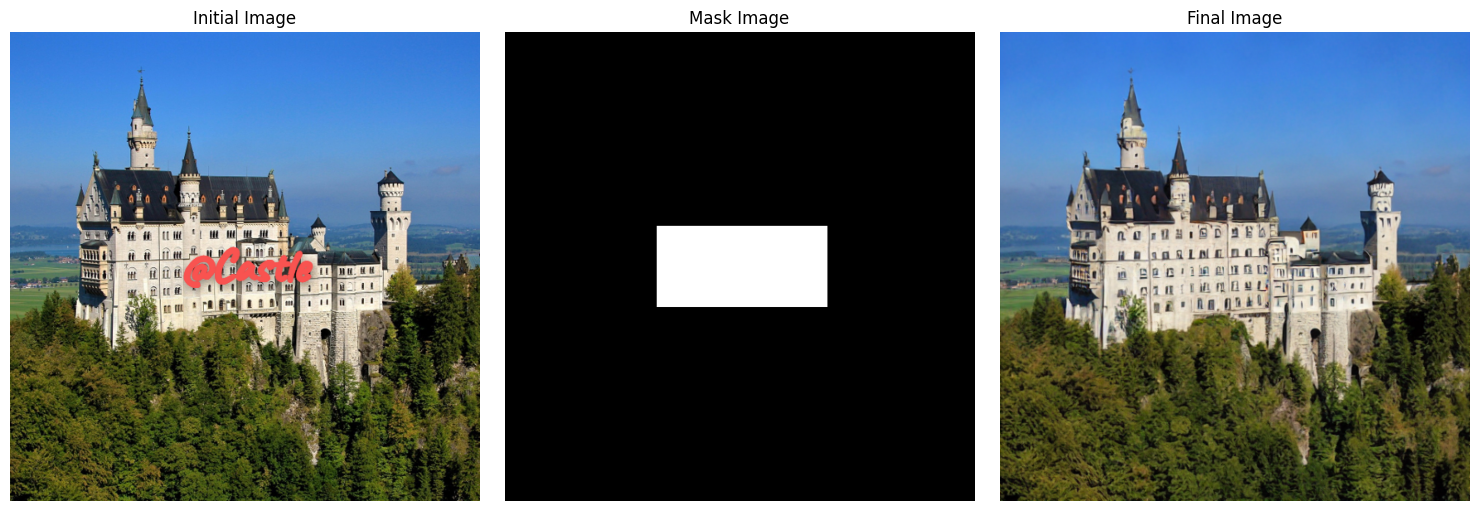

In [18]:
# show the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the first image (initial image)
axes[0].imshow(init_image)
axes[0].set_title('Initial Image')
axes[0].axis('off')

# Display the second image (mask image)
axes[1].imshow(mask_image, cmap="gray")
axes[1].set_title('Mask Image')
axes[1].axis('off')

# Display the third image (processed image)
axes[2].imshow(final_image)
axes[2].set_title('Final Image')
axes[2].axis('off')

plt.tight_layout()

plt.show()